### STEP 7 : 다른 주식 종목 예측해 보기_NAVER

In [1]:
import pandas as pd
import sklearn
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# print(pandas.__version__)
# print(sklearn.__version__)
# print(statsmodels.__version__)

__데이터셋 준비__

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

path = "~/aiffel/stock_prediction/data/"
df = pd.read_csv(f"{path}LULU.csv", index_col = "Date", parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-20,418.100006,425.299988,412.489990,419.529999,419.529999,971500
2021-09-21,422.390015,426.700012,419.549988,424.190002,424.190002,610900
2021-09-22,425.119995,431.279999,422.010010,431.179993,431.179993,948500
2021-09-23,433.000000,437.320007,430.000000,431.910004,431.910004,1490100
2021-09-24,427.440002,433.609985,424.070007,432.609985,432.609985,873300


In [3]:
ts = df["Close"]
ts

Date
2021-09-20    419.529999
2021-09-21    424.190002
2021-09-22    431.179993
2021-09-23    431.910004
2021-09-24    432.609985
                 ...    
2022-09-13    337.320007
2022-09-14    342.920013
2022-09-15    338.600006
2022-09-16    333.239990
2022-09-19    337.079987
Name: Close, Length: 252, dtype: float64

### STEP 2 :  각종 전처리 수행

In [4]:
# 결측치 처리
ts = ts.interpolate(method = "time")
ts[ts.isna()]
# 결측치가 없음

Series([], Name: Close, dtype: float64)

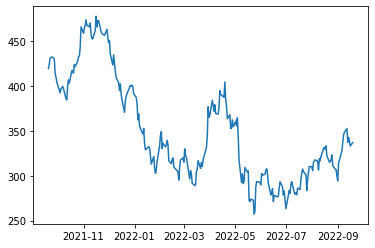

In [5]:
# 원본 데이터 
plt.plot(ts)

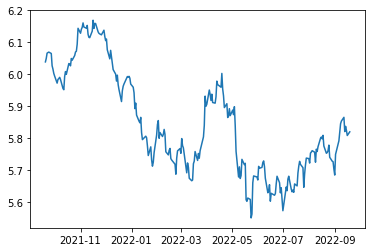

In [6]:
# 로그 변환
ts_log = np.log(ts)

# 로그 변환 그래프
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

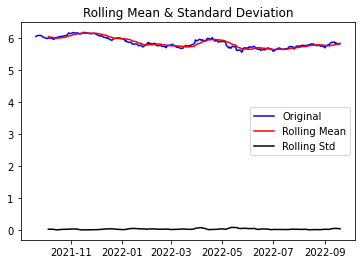

Results of Dickey-Fuller Test:
Test Statistic                  -1.662924
p-value                          0.450309
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


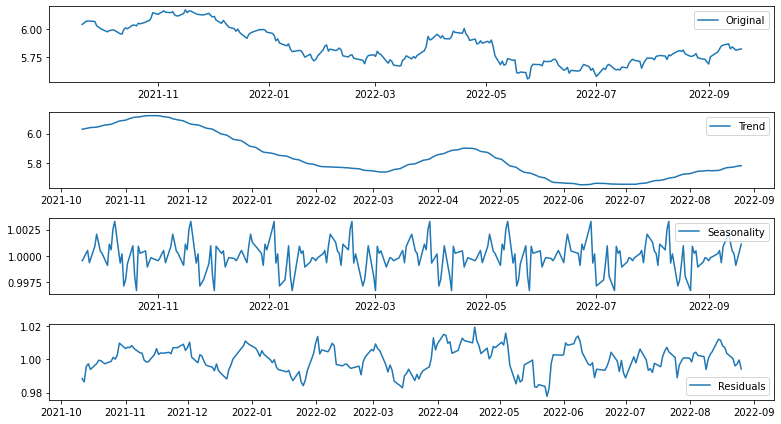

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.111779
p-value                          0.000013
#Lags Used                       1.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


- p-value가 충분히 작아서 안정성이 높다고 볼 수 있다. 

### STEP 4 : 학습, 테스트 데이터셋 생성

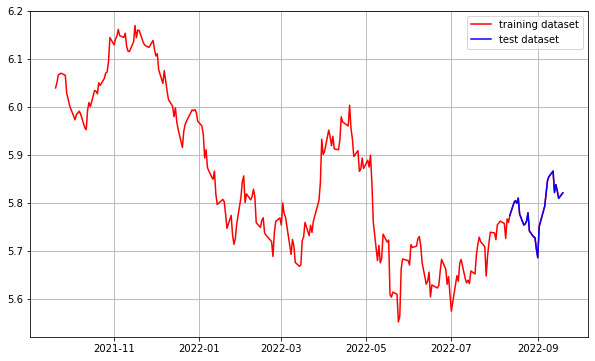

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

### STEP 5 : 적정 ARIMA 모수 찾기

__원본 데이터__

Results of Dickey-Fuller Test:
Test Statistic                  -1.662924
p-value                          0.450309
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


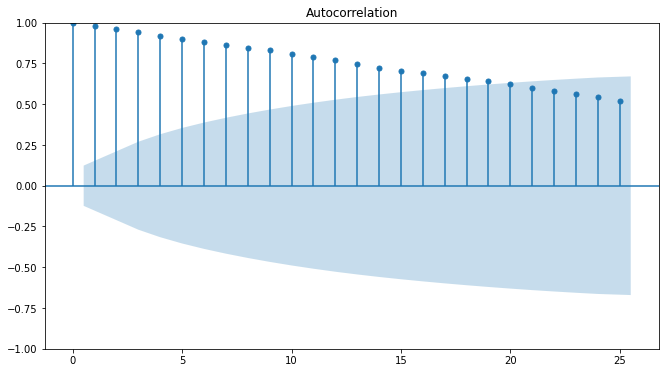

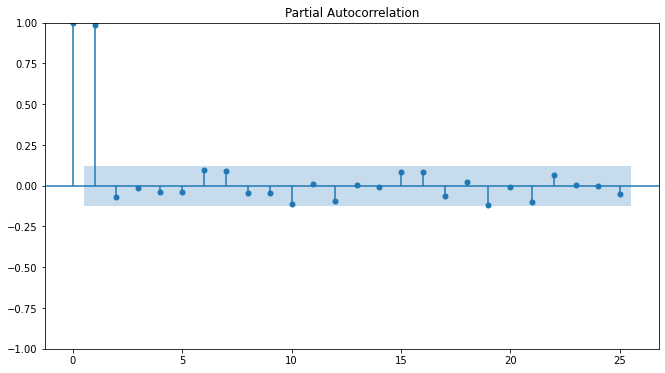

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

augmented_dickey_fuller_test(ts_log)

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

__1차 차분__

Results of Dickey-Fuller Test:
Test Statistic                -1.514220e+01
p-value                        6.985109e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


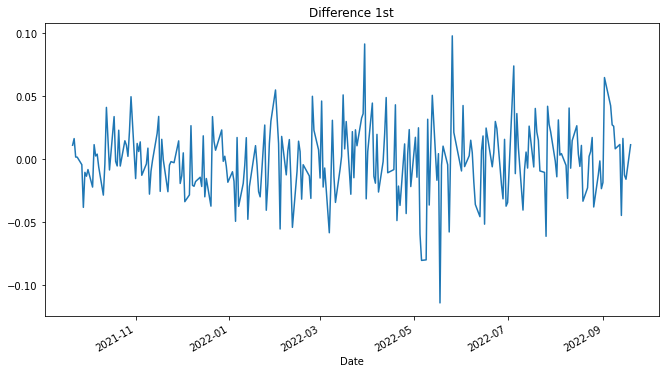

In [13]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]  #diff 차분 인자
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


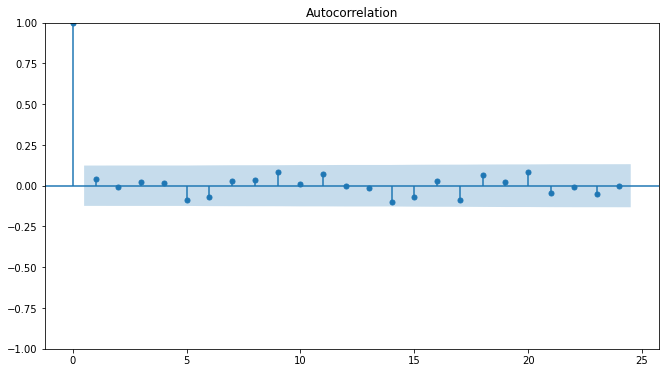

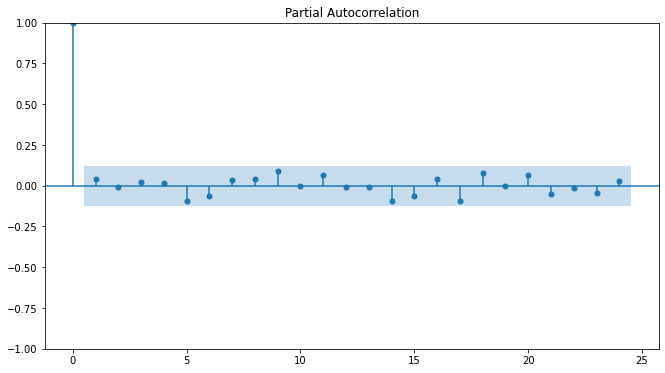

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

__2차 차분__

Results of Dickey-Fuller Test:
Test Statistic                -9.154469e+00
p-value                        2.632493e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


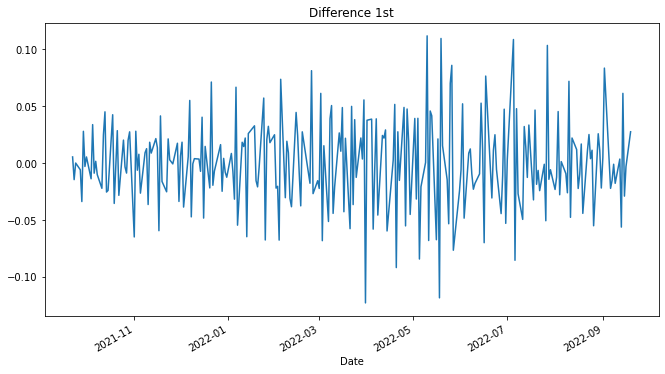

In [15]:
# 2 차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]  #diff 차분 인자
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


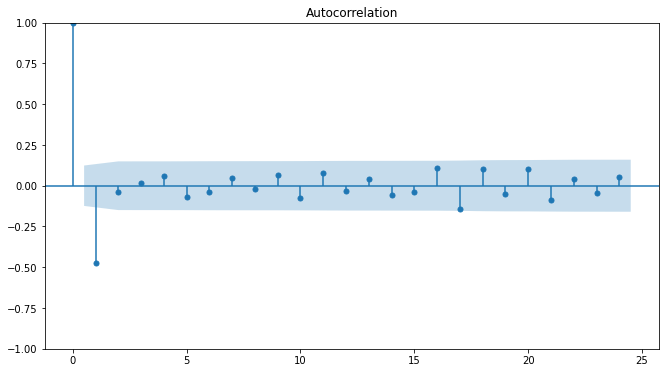

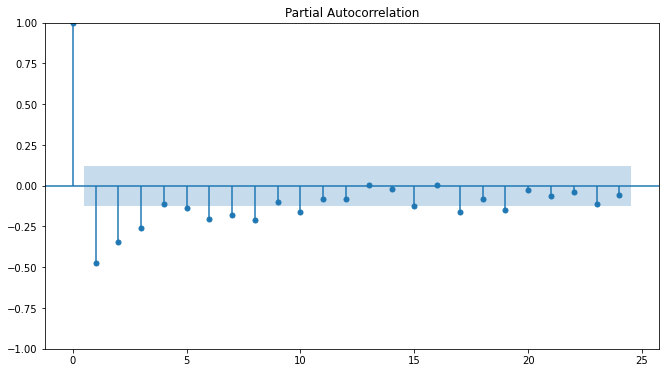

In [16]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### STEP 6 : ARIMA 모델 훈련과 테스트

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 , (p,d,q)
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 480.502
Date:                Tue, 20 Sep 2022   AIC                           -953.005
Time:                        11:22:43   BIC                           -939.322
Sample:                             0   HQIC                          -947.483
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8686      0.100     58.440      0.000       5.672       6.065
ar.L1          0.9833      0.013     74.642      0.000       0.957       1.009
ma.L1          0.0342      0.067      0.509      0.6

__예측__

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


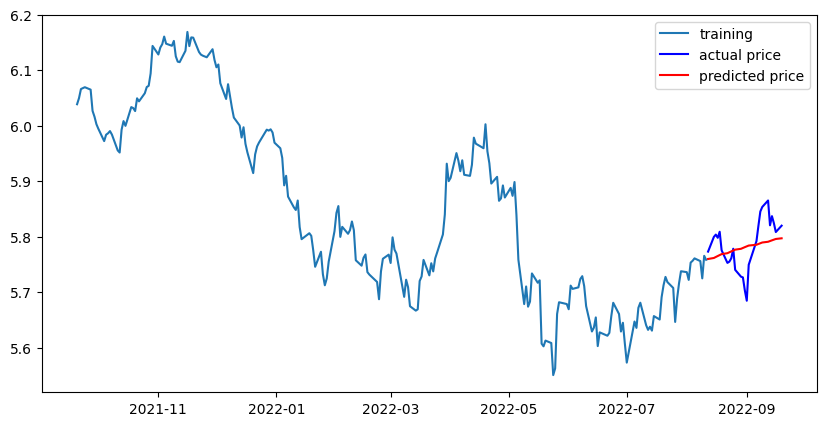

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  195.90045240557396
MAE:  11.794624275237323
RMSE:  13.996444277228912
MAPE: 3.64%


### 회고

- 다행스럽게도 3.64%가 나왔다. 
- 시계열을 개념을 이해하는 것 부터 하이퍼 파라미터 튜닝까지 너무 어려운 파트인 것 같다. 
- 나중에 시계열을 다시 볼 일이 있을 것 같은데 시간날 때 공부를 해야겠다. 